In [7]:
# What we need for the tasks:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
import string

# To use the capability of NLTK to remove the stopwords. 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

# To get the sentiments, I used the textblob package:
# pip install textblob
from textblob import TextBlob

# To make wordcloud:
#pip install wordcloud
from wordcloud import WordCloud

# For topic modeling:
#pip install gensim
import gensim
from gensim import matutils, models
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse
from nltk import word_tokenize, pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# pip install pyLDAvis
# pip install spacy
# The pyLDAvis gensim name changed.
# When I use gensim_models rather than gensim the interactive viz works.
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
#import pyLDAvis.gensim
import gensim.corpora as corpora
from pprint import pprint
import spacy
# import logging, warnings     --> Not sure if these are really requiered!
from gensim.utils import simple_preprocess
# make sure to add this one:
# python -m spacy download en  # run in terminal once
# python -m spacy download en_core_web_sm # run in terminal once

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RezaAbdi.AzureAD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RezaAbdi.AzureAD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\RezaAbdi.AzureAD\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [8]:
# Reading in the raw file -combined file from  3 weeks of streaming- 
# The input file include the userID, username, the actual text, number of RTs and Likes

df_0 = pd.read_csv("All_tweets.csv")
df = df_0.dropna()

# To remove the b' from text and decode it from utf-8
df['Text'] = df['Text'].apply(ast.literal_eval).str.decode("utf-8")

df.head(5)

DateTime        UserID       UserName  \
0  9/3/2020 23:59  8.430000e+17    CalBluebird   
1  9/3/2020 23:59  8.731312e+06  DenverChannel   
2  9/3/2020 23:58  1.303508e+08    StephonJS87   
3  9/3/2020 23:57  1.160000e+18   roboticscats   
4  9/3/2020 23:54  1.678503e+07      WMAR2News   

                                                Text  RT  Likes     Dates  \
0  As fires loomed closer to the sanctuary of Cal...   1      1  9/3/2020   
1  On Friday, the BLM and White River National Fo...   0      2  9/3/2020   
2  @sunbIasts He already did that last nightm it ...   0      0  9/3/2020   
3  If you see a #wildfire, you click the wildfire...   1      2  9/3/2020   
4  Wildfires are causing concern for sensitive gr...   0      0  9/3/2020   

       Time  
0  23:59:00  
1  23:59:00  
2  23:58:00  
3  23:57:00  
4  23:54:00

# Step 1: Working on keyword "wildfire" along w/ "climate"

In [9]:
# Here, I want to see the number of tweets I have streamed with my desired key words
# I wanna see before, during, and after the wildfires how was the people's reaction by 
# tweeting with those words.

# Starting with some text mininig steps:
df["Text"] = df["Text"].str.lower()
exactmatch = ['climate', 'climate change']
df['Target'] = df["Text"].str.findall(r"|".join(exactmatch)).apply(", ".join)

df_wFireNm = pd.concat([df['Dates'], df['Target']], axis=1)
df_wFireNm['Target'].replace('', np.nan, inplace=True)
df_wFireNm.dropna(subset=['Target'], inplace=True)
df_wFireNm['Dates']=pd.to_datetime(df_wFireNm['Dates'])
df_wFireNm.sort_values(by=['Dates'], inplace=True, ascending=True)

CC_patternNm=df_wFireNm['Target'].groupby(df_wFireNm['Dates']).size().reset_index(name='counts')

#CC_patternNm.to_csv('CC_Pattern.csv')


# Some more Text Mininig using RE

In [10]:
df["Text"] = df["Text"].str.lower()
df["Text"] = df["Text"].str.replace('\d+', '')
df["Text"] = df["Text"].str.replace('#', '')

# To remove all the garbages including the URLs: 
no_URL_mention = []

# I wrote a for loop to include all the RE related steps in one try for each tweet:
for text in (df['Text']):
    processed_text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text)
    processed_text = " ".join(processed_text.split())
    processed_text2 = re.sub("@[A-Za-z0-9]+","", processed_text)
    processed_text3 = " ".join(processed_text2.split())
    
    no_URL_mention.append(processed_text3)

df_proc = pd.DataFrame(no_URL_mention,columns=['Text_p'])
# To remove the @ signs:
df_proc['Text_p']=df_proc['Text_p'].str.replace('@', '')


# Re-encoding the code for further cleaning:
no_punc = []
no_enc = []

for text in (df_proc['Text_p']):
    encoded_text = text.encode("ascii", "ignore")
    no_enc.append(encoded_text)

df_proc2 = pd.DataFrame(no_enc,columns=['Text_p'])

for text in range(0, len(df_proc2)):
    #exclude = set(string.punctuation)
    #text = ''.join(ch for ch in text if ch not in exclude)
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(df_proc2['Text_p'][text]))
    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    processed_feature = re.sub(r'\b\w{1,2}\b', '', processed_feature)

    exclude = set(string.punctuation)
    text = ''.join(ch for ch in processed_feature if ch not in exclude)
    
    no_punc.append(text)
    
df_proc2 = pd.DataFrame(no_punc,columns=['Text_p'])


<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
C:\Users\REZAAB~1.AZU\AppData\Local\Temp/ipykernel_19264/1460317186.py:2: DeprecationWarning: invalid escape sequence \d
  df["Text"] = df["Text"].str.replace('\d+', '')
C:\Users\REZAAB~1.AZU\AppData\Local\Temp/ipykernel_19264/1460317186.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Text"] = df["Text"].str.replace('\d+', '')


NLTK is a leading platform for building Python programs to work with human language data. It provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning, wrappers for industrial-strength NLP libraries, and an active discussion forum.

https://www.nltk.org/index.html#

In [11]:
# Here in the next step, I use the NLTK to clean up more:
#nltk.download('stopwords')
#from nltk.corpus import stopwords
#stop = stopwords.words('english')

# Here I remove those stopwords:
df_proc3 = pd.DataFrame()
df_proc3['Text_c']=df_proc2['Text_p'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# To make a dataframe for the words after the previous clean up:
df_proc4 = pd.DataFrame(df_proc3['Text_c'])

df_proc4['split'] = df_proc3['Text_c'].str.split()
df_proc4['Length'] = df_proc4['split'].str.len()

last = df_proc4['Length'] > 2
df_proc5 = df_proc4[last]


TextBlob is a Python (2 and 3) library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more.

https://textblob.readthedocs.io/en/dev/

In [12]:
#from textblob import TextBlob

#Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#Create two new columns
df_proc5['Subjectivity'] = df_proc5['Text_c'].apply(getSubjectivity)
df_proc5['Polarity'] = df_proc5['Text_c'].apply(getPolarity)

#Show the new dataframe with the new columns
#df_proc5.head(5)

C:\Users\REZAAB~1.AZU\AppData\Local\Temp/ipykernel_19264/1106542565.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proc5['Subjectivity'] = df_proc5['Text_c'].apply(getSubjectivity)
C:\Users\REZAAB~1.AZU\AppData\Local\Temp/ipykernel_19264/1106542565.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proc5['Polarity'] = df_proc5['Text_c'].apply(getPolarity)


WordCloud for Python documentation

Here you find instructions on how to create wordclouds with my Python wordcloud project. Compared to other wordclouds, my algorithm has the advantage of
filling all available space.
being able to use arbitraty masks.
having a stupid simple algorithm (with an efficient implementation) that can be easily modified.
being in Python
Check out the Gallery of Examples here: https://amueller.github.io/word_cloud/auto_examples/index.html#example-gallery

https://amueller.github.io/word_cloud/

(-0.5, 799.5, 479.5, -0.5)

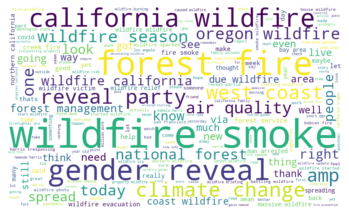

In [13]:
from wordcloud import WordCloud

#Plot the word cloud
allWords = ' '.join([twts for twts in df_proc5['Text_c']])
wordCloud = WordCloud(width = 800, height=480, random_state=21, max_font_size = 119,background_color='white').generate(allWords)

plt.imshow(wordCloud,interpolation='bilinear')
plt.axis('off')

#plt.savefig('public_wordCloud.tiff', format='tiff', dpi=300)

In [14]:
#Create a function to compute the negative, nutural, and positive analysis
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
df_proc5['Analysis'] = df_proc5['Polarity'].apply(getAnalysis)

#df_proc5.head(10)

C:\Users\REZAAB~1.AZU\AppData\Local\Temp/ipykernel_19264/2464023045.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proc5['Analysis'] = df_proc5['Polarity'].apply(getAnalysis)


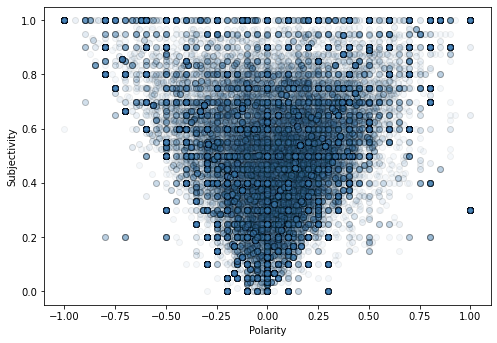

In [15]:
#plot the polarity and subjectivity
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6),facecolor="#FFFFFF",edgecolor="#00FF00")
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index
ax = plt.scatter(df_proc5['Polarity'], df_proc5['Subjectivity'],color='steelblue',edgecolors='black',alpha=0.05);
#ax.set_facecolor('white')    
ax = plt.gca()
ax.grid(False)
ax = plt.rcParams["axes.edgecolor"] = "black"
ax = plt.rcParams["axes.linewidth"] = 1
ax = plt.subplots_adjust(bottom=0.19)

#plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

#plt.savefig('sentimentAnalysis_1.tiff', format='tiff', dpi=300)

C:\Users\REZAAB~1.AZU\AppData\Local\Temp/ipykernel_19264/2506261769.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_main.set_xticklabels(xlabels)


[Text(-1.25, 0, '-1.25'),
 Text(-1.0, 0, '-1.0'),
 Text(-0.75, 0, '-0.75'),
 Text(-0.5, 0, '-0.5'),
 Text(-0.25, 0, '-0.25'),
 Text(0.0, 0, '0.0'),
 Text(0.25, 0, '0.25'),
 Text(0.5, 0, '0.5'),
 Text(0.75, 0, '0.75'),
 Text(1.0, 0, '1.0'),
 Text(1.25, 0, '1.25')]

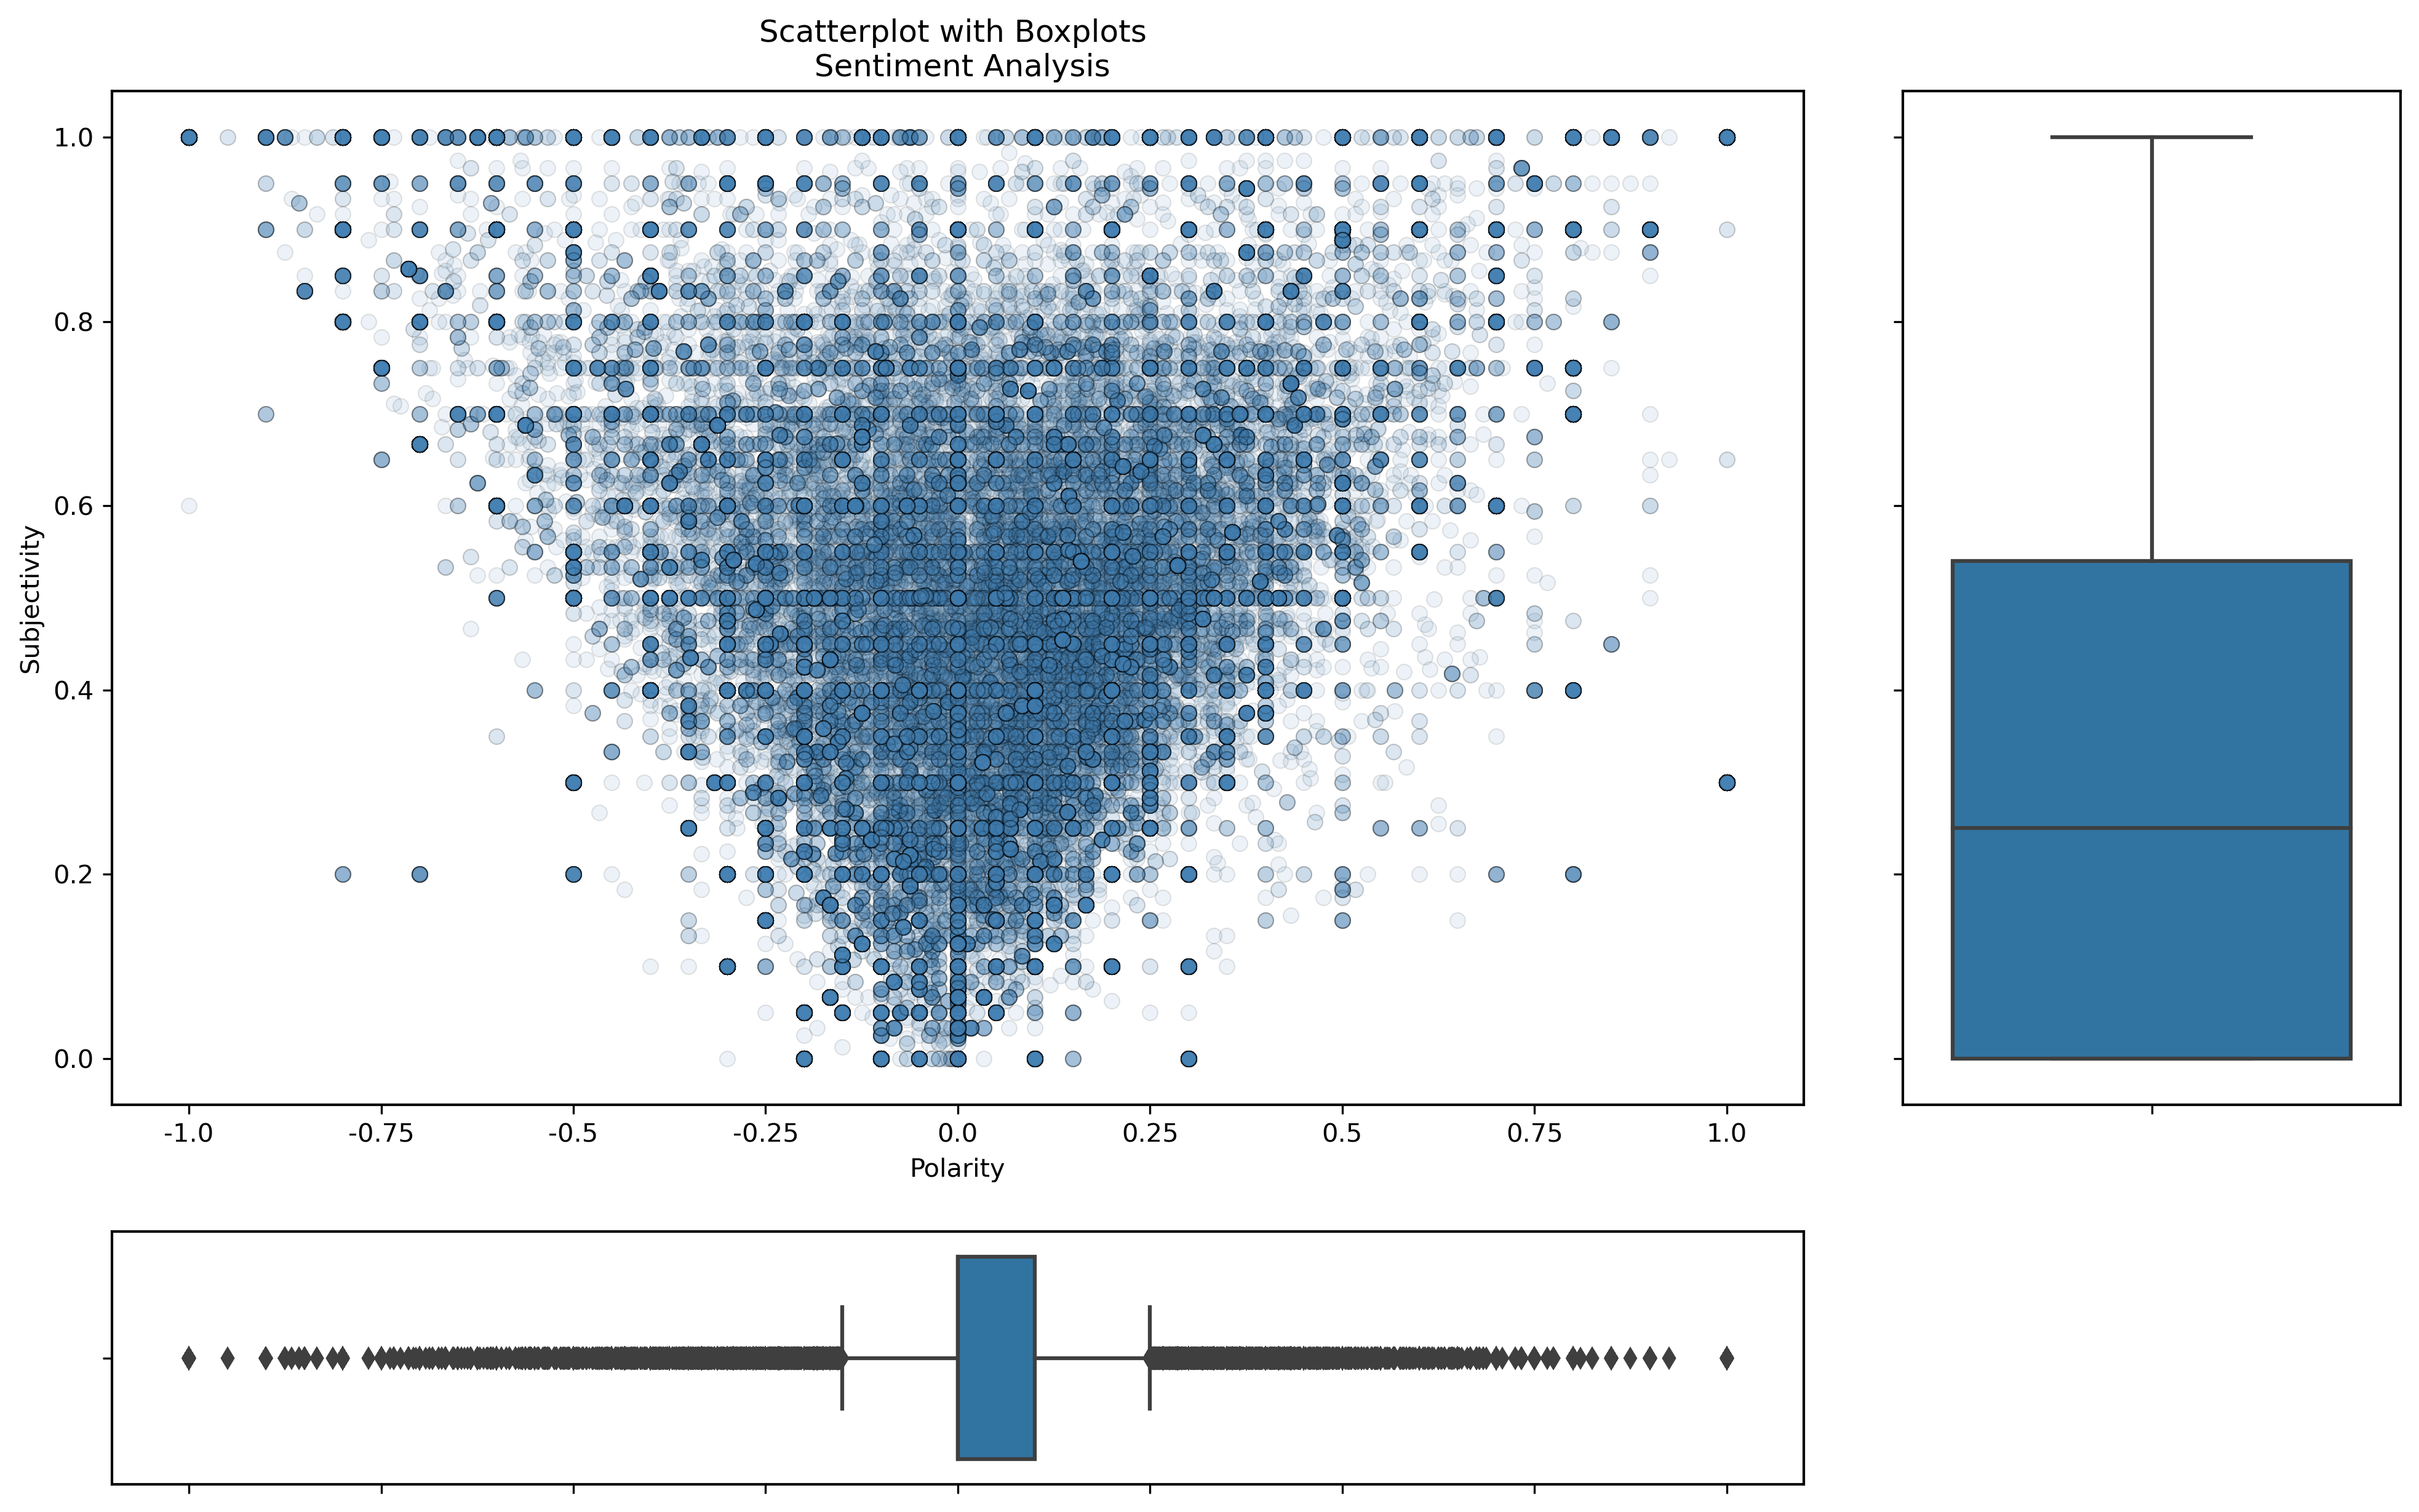

In [16]:
# Create Fig and gridspec
fig = plt.figure(figsize=(16, 10), dpi= 300,edgecolor="#00FF00")
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# Define the axes
ax_main = fig.add_subplot(grid[:-1, :-1])
ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])
ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])

# Scatterplot on main ax
ax_main.scatter(df_proc5['Polarity'], df_proc5['Subjectivity'],color='steelblue',
                edgecolors='black',alpha=0.1, linewidths=.5)

# histogram on the right
#ax_bottom.hist(df_proc5['Polarity'], 40, histtype='stepfilled', orientation='vertical', color='royalblue')
#ax_bottom.invert_yaxis()

# histogram in the bottom
#ax_right.hist(df_proc5['Subjectivity'], 40, histtype='stepfilled', orientation='horizontal', color='royalblue')

# Bar boxplots in side panels
sns.boxplot(y=df_proc5['Subjectivity'], ax=ax_right, orient="v")
sns.boxplot(x=df_proc5['Polarity'], ax=ax_bottom, orient="h")

ax_bottom.set(xlabel='')
ax_right.set(ylabel='', xlabel = '')

# Decorations
#ax_main.set(title='Scatterplot with Histograms \n Sentiment Analysis', xlabel='Polarity', ylabel='Subjectivity')
ax_main.set(title='Scatterplot with Boxplots \n Sentiment Analysis', xlabel='Polarity', ylabel='Subjectivity')


xlabels = ax_main.get_xticks().tolist()
ax_main.set_xticklabels(xlabels)
#plt.show()

#plt.savefig('sentimentAnalysis_2.tiff', format='tiff', dpi=300)

<Figure size 864x720 with 0 Axes>

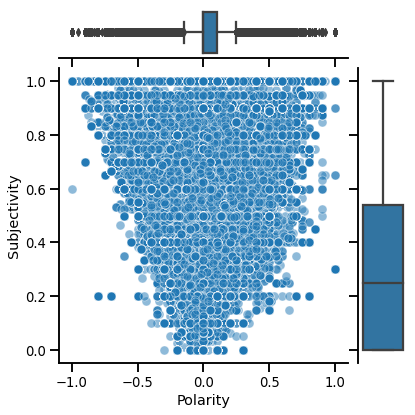

In [17]:
# type 1 of visualization
#g = sns.JointGrid(data=df_proc5, x="Polarity", y="Subjectivity")
#g.plot_joint(sns.histplot)
#g.plot_marginals(sns.boxplot)

# set plot context to set plot sizes 
# type 2 of visualization
sns.set_context("talk", font_scale=0.8)
plt.figure(figsize=(12,10))
g = sns.JointGrid(data=df_proc5, x="Polarity", y="Subjectivity")
g.plot_joint(sns.scatterplot, alpha = 0.5)
g.plot_marginals(sns.boxplot)

# Step 2: Working on keyword "climate change" only

In [18]:
df_0 = pd.read_csv("with_ClimateChnage.csv")
df = df_0.dropna()


In [19]:
df["Text"] = df["Text"].str.lower()
df["Text"] = df["Text"].str.replace('\d+', '')
df["Text"] = df["Text"].str.replace('#', '')
df["Text"] = df["Text"].str.replace('&', '')
df["Text"] = df["Text"].str.replace('"', '')

no_URL_mention = []

for text in (df['Text']):
    processed_text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text)
    processed_text = " ".join(processed_text.split())
    processed_text2 = re.sub("@[A-Za-z0-9]+","", processed_text)
    processed_text3 = " ".join(processed_text2.split())
    
    no_URL_mention.append(processed_text3)
    
df_proc = pd.DataFrame(no_URL_mention,columns=['Text_p'])
df_proc['Text_p']=df_proc['Text_p'].str.replace('@', '')

#df_proc.head(5)

<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
C:\Users\REZAAB~1.AZU\AppData\Local\Temp/ipykernel_19264/2300252721.py:2: DeprecationWarning: invalid escape sequence \d
  df["Text"] = df["Text"].str.replace('\d+', '')
C:\Users\REZAAB~1.AZU\AppData\Local\Temp/ipykernel_19264/2300252721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Text"] = df["Text"].str.lower()
C:\Users\REZAAB~1.AZU\AppData\Local\Temp/ipykernel_19264/2300252721.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Text"] = df["Text"].str.replace('\d+', '')
C:\Users\REZAAB~1.AZU\AppData\Local\Temp/ipykernel_19264/2300252721.py:2: SettingWithCopyWarning: 
A value 

In [20]:
no_punc = []
no_enc = []

for text in (df_proc['Text_p']):
    encoded_text = text.encode("ascii", "ignore")
    no_enc.append(encoded_text)

df_proc2 = pd.DataFrame(no_enc,columns=['Text_p'])

for text in range(0, len(df_proc2)):
    #exclude = set(string.punctuation)
    #text = ''.join(ch for ch in text if ch not in exclude)
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(df_proc2['Text_p'][text]))
    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    processed_feature = re.sub(r'\b\w{1,2}\b', '', processed_feature)

    exclude = set(string.punctuation)
    text = ''.join(ch for ch in processed_feature if ch not in exclude)
    
    no_punc.append(text)
    
df_proc2 = pd.DataFrame(no_punc,columns=['Text_p'])
#df_proc2.head(5)

In [21]:
df_proc3 = pd.DataFrame()
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 
                   'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 
                   'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make',
                   'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may',
                   'take', 'come'])
df_proc3['Text_c']=df_proc2['Text_p'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

df_proc4 = pd.DataFrame(df_proc3['Text_c'])

df_proc4['split'] = df_proc3['Text_c'].str.split()
df_proc4['Length'] = df_proc4['split'].str.len()

last = df_proc4['Length'] > 2
df_proc5 = df_proc4[last]

#df_proc5.head(5)

In [22]:
#Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#Create two new columns
df_proc5['Subjectivity'] = df_proc5['Text_c'].apply(getSubjectivity)
df_proc5['Polarity'] = df_proc5['Text_c'].apply(getPolarity)

#Shew the new dataframe with the new columns
#df_proc5.head(10)

C:\Users\REZAAB~1.AZU\AppData\Local\Temp/ipykernel_19264/3188632670.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proc5['Subjectivity'] = df_proc5['Text_c'].apply(getSubjectivity)
C:\Users\REZAAB~1.AZU\AppData\Local\Temp/ipykernel_19264/3188632670.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proc5['Polarity'] = df_proc5['Text_c'].apply(getPolarity)


(-0.5, 799.5, 479.5, -0.5)

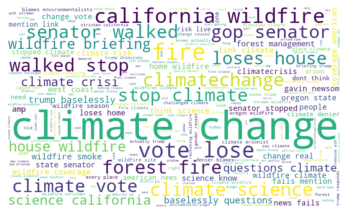

In [23]:

allWords = ' '.join([twts for twts in df_proc5['Text_c']])
wordCloud = WordCloud(width = 800, height=480, random_state=21, max_font_size = 119,
                      background_color='white').generate(allWords)

plt.imshow(wordCloud,interpolation='bilinear')
plt.axis('off')

C:\Users\REZAAB~1.AZU\AppData\Local\Temp/ipykernel_19264/2209146861.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_main.set_xticklabels(xlabels)


[Text(-1.25, 0, '-1.25'),
 Text(-1.0, 0, '-1.0'),
 Text(-0.75, 0, '-0.75'),
 Text(-0.5, 0, '-0.5'),
 Text(-0.25, 0, '-0.25'),
 Text(0.0, 0, '0.0'),
 Text(0.25, 0, '0.25'),
 Text(0.5, 0, '0.5'),
 Text(0.75, 0, '0.75'),
 Text(1.0, 0, '1.0'),
 Text(1.25, 0, '1.25')]

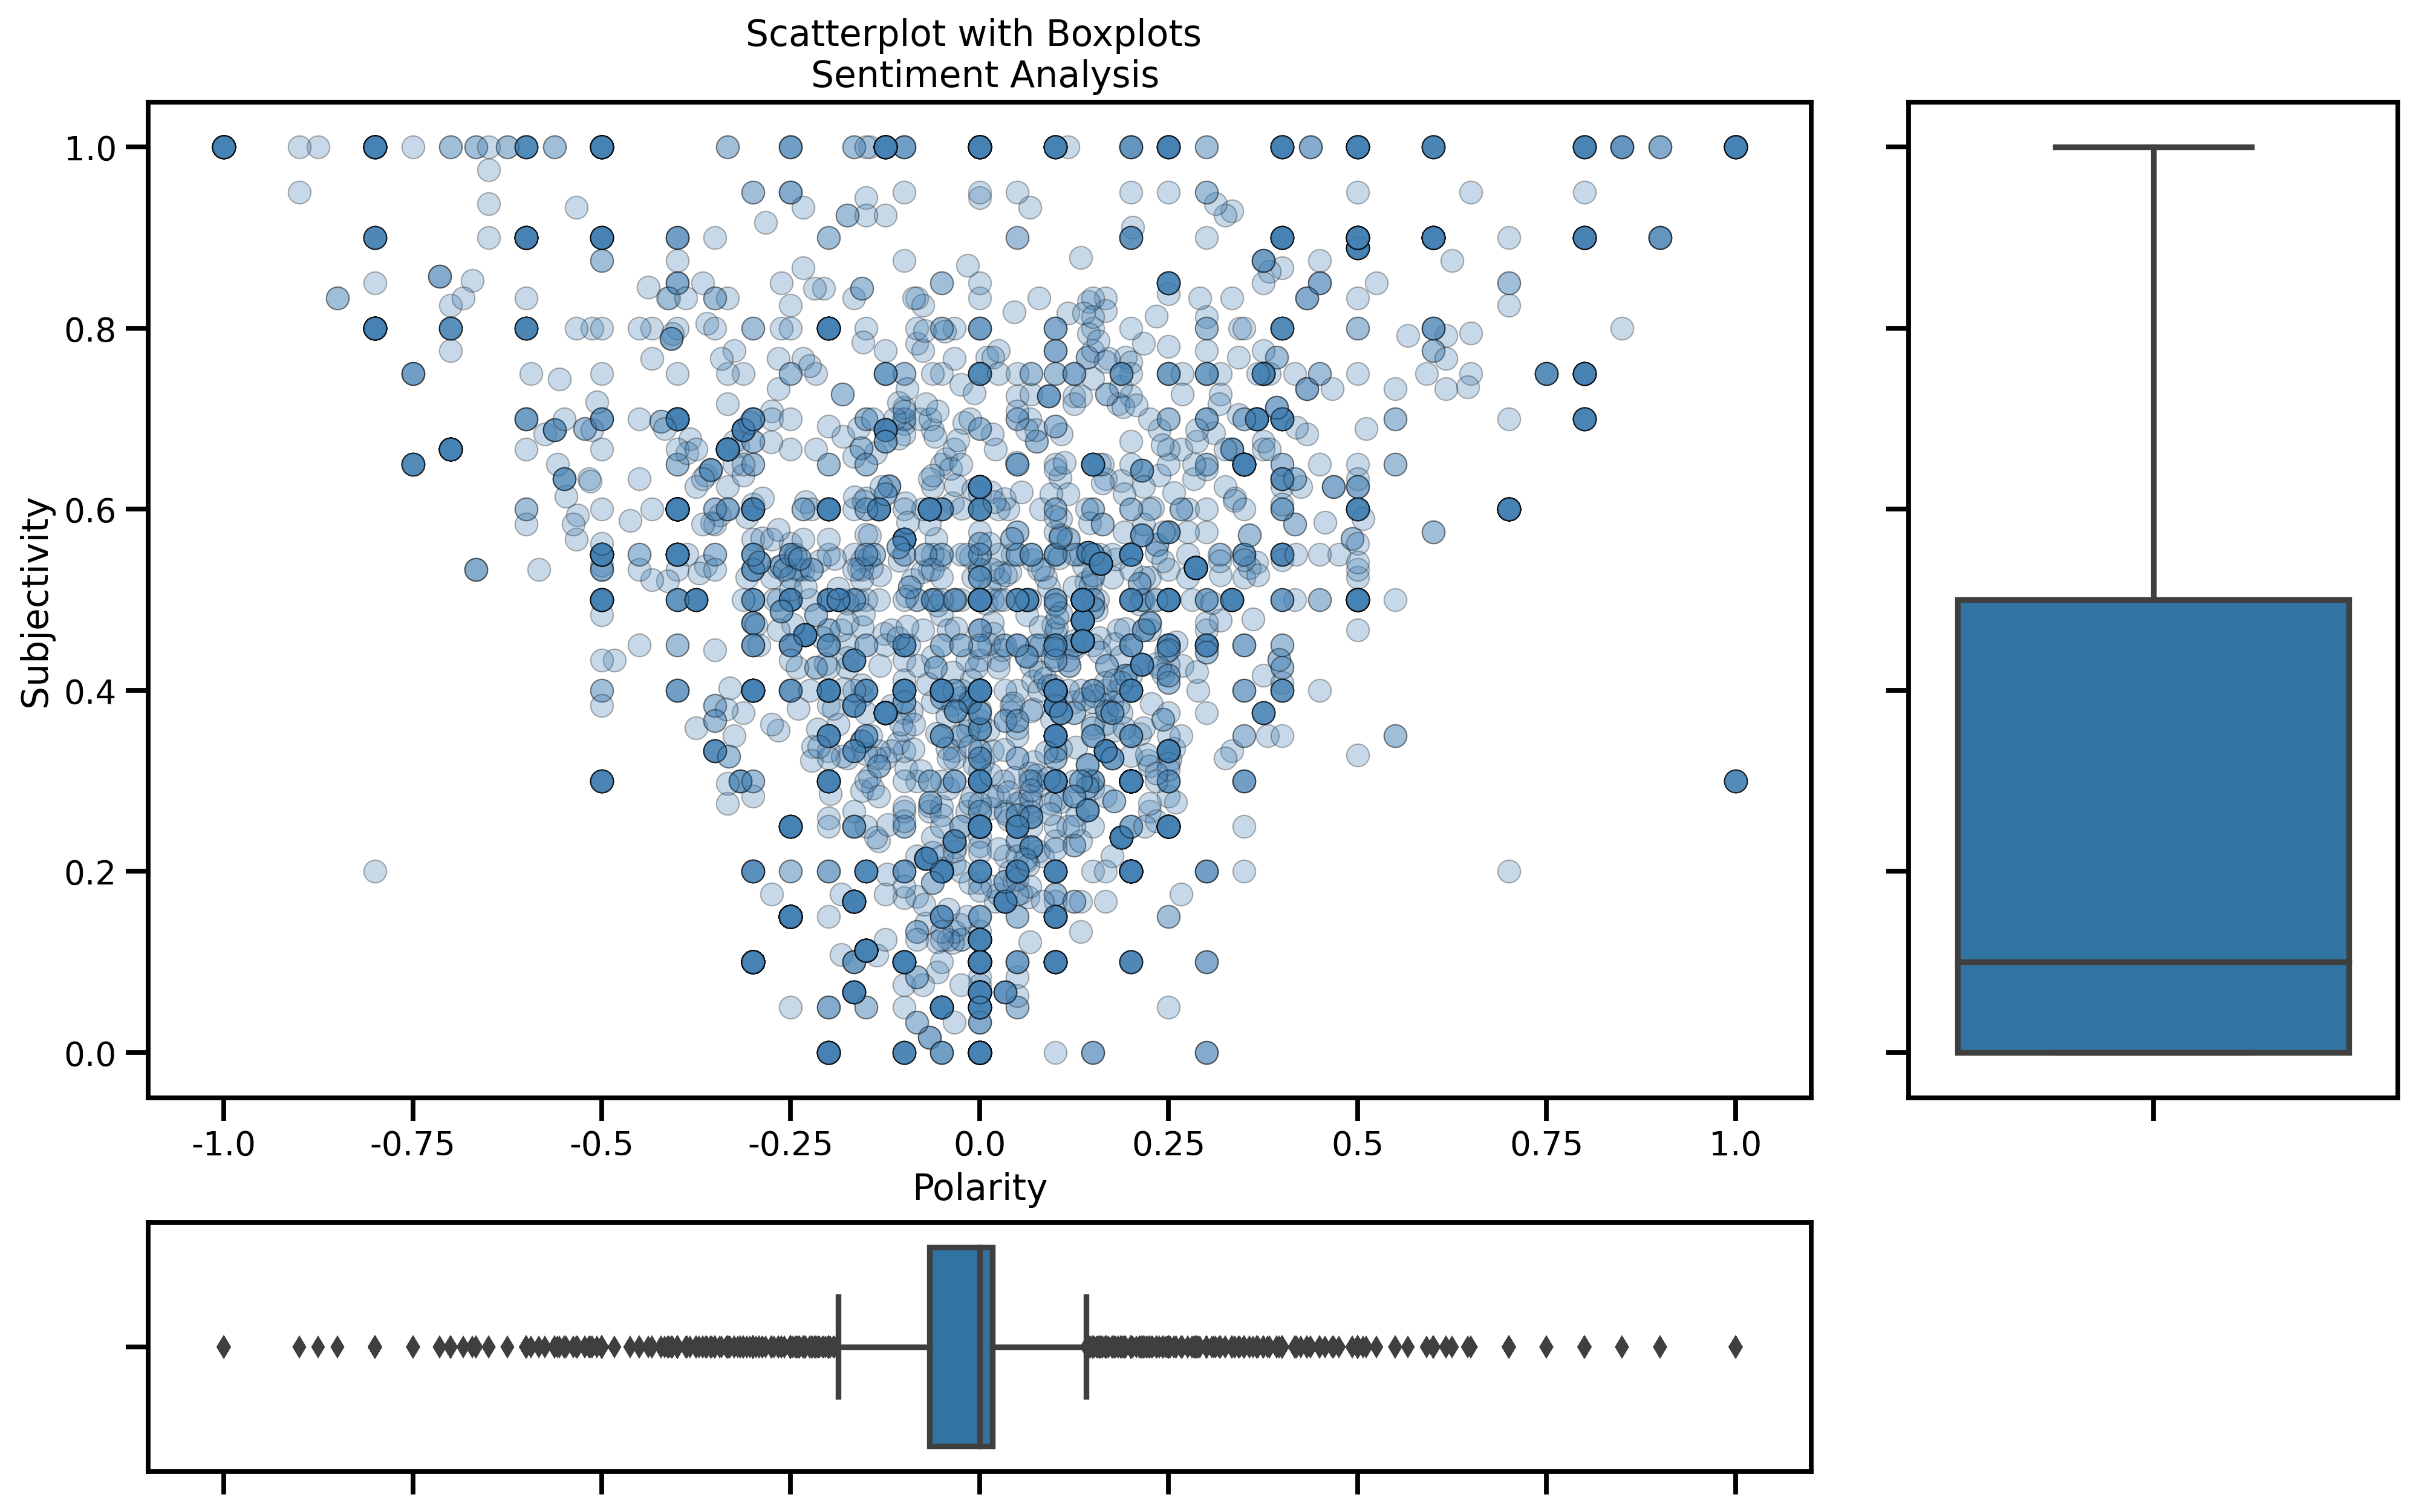

In [24]:
# Create Fig and gridspec
fig = plt.figure(figsize=(16, 10), dpi= 300,edgecolor="#00FF00")
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# Define the axes
ax_main = fig.add_subplot(grid[:-1, :-1])
ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])
ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])

# Scatterplot on main ax
ax_main.scatter(df_proc5['Polarity'], df_proc5['Subjectivity'],color='steelblue',edgecolors='black',alpha=0.3, linewidths=.5)

# histogram on the right
#ax_bottom.hist(df_proc5['Polarity'], 40, histtype='stepfilled', orientation='vertical', color='royalblue')
#ax_bottom.invert_yaxis()

# histogram in the bottom
#ax_right.hist(df_proc5['Subjectivity'], 40, histtype='stepfilled', orientation='horizontal', color='royalblue')

# Add a graph in each part
sns.boxplot(y=df_proc5['Subjectivity'], ax=ax_right, orient="v")
sns.boxplot(x=df_proc5['Polarity'], ax=ax_bottom, orient="h")

# Decorations
#ax_main.set(title='Scatterplot with Histograms \n Sentiment Analysis', xlabel='Polarity', ylabel='Subjectivity')
ax_bottom.set(xlabel='')
ax_right.set(ylabel='')
# Decorations
ax_main.set(title='Scatterplot with Boxplots \n Sentiment Analysis', xlabel='Polarity', ylabel='Subjectivity')

xlabels = ax_main.get_xticks().tolist()
ax_main.set_xticklabels(xlabels)
#plt.show()

#plt.savefig('sentimentAnalysis_3ClimateChange.tiff', format='tiff', dpi=300)


# Topic modeling steps 

What we need for topic modeling: 

#pip install gensim \
from gensim import matutils, models \
from sklearn.feature_extraction import text \
from sklearn.feature_extraction.text import CountVectorizer \
import scipy.sparse \
from nltk import word_tokenize, pos_tag 

Gensim is a free open-source Python library for representing documents as semantic vectors, as efficiently (computer-wise) and painlessly (human-wise) as possible. \

https://radimrehurek.com/gensim/

In [25]:
# This step will take some time:

# Let's create a function to pull out nouns from a string of text
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

# Apply the nouns function to the tweets to filter only on nouns
data_nouns_adj = pd.DataFrame(df_proc5.Text_c.apply(nouns_adj))
#data_nouns_adj.head(5)

# Create a new document-term matrix using only nouns and adjectives, 
# also remove common words with max_df
cvna = CountVectorizer(max_df=.8)  #
data_cvna = cvna.fit_transform(data_nouns_adj.Text_c)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj.index
#data_dtmna.head(5)

# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

# Let's try 4 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=100)
ldana.print_topics()

C:\Users\RezaAbdi.AzureAD\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[(0,
  '0.126*"climate" + 0.097*"change" + 0.043*"fire" + 0.043*"forest" + 0.026*"fires" + 0.019*"wildfire" + 0.015*"risk" + 0.013*"management" + 0.009*"west" + 0.009*"wildfires"'),
 (1,
  '0.096*"climate" + 0.080*"wildfire" + 0.034*"house" + 0.032*"stop" + 0.031*"vote" + 0.030*"senator" + 0.030*"gop" + 0.023*"crisis" + 0.023*"news" + 0.014*"biden"'),
 (2,
  '0.081*"wildfire" + 0.070*"california" + 0.064*"climate" + 0.056*"trump" + 0.056*"science" + 0.043*"change" + 0.023*"oregon" + 0.022*"state" + 0.022*"briefing" + 0.020*"questions"'),
 (3,
  '0.099*"climate" + 0.080*"change" + 0.055*"wildfire" + 0.015*"newsom" + 0.015*"oregon" + 0.013*"season" + 0.011*"climatechange" + 0.010*"denier" + 0.010*"gavin" + 0.009*"fires"')]

--------------------------------------\
I need to import gensim for the next step:

Gensim is an open-source library for unsupervised topic modeling and natural language processing, \
using modern statistical machine learning. \
https://en.wikipedia.org/wiki/Gensim

Gensim is implemented in Python and Cython for performance. \
Gensim is designed to handle large text collections using data streaming and incremental 
online algorithms, which differentiates it from most other machine learning software \
packages that target only in-memory processing.

In [26]:
# Continue working with the nouns I extracted previously

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = data_nouns_adj.Text_c.values.tolist()
data_words = list(sent_to_words(data))

# The topic that has the most discussion around it:
print(data_words[:1])

<>:5: DeprecationWarning: invalid escape sequence \S
<>:6: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \S
<>:6: DeprecationWarning: invalid escape sequence \s
C:\Users\REZAAB~1.AZU\AppData\Local\Temp/ipykernel_19264/2970125558.py:5: DeprecationWarning: invalid escape sequence \S
  sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
C:\Users\REZAAB~1.AZU\AppData\Local\Temp/ipykernel_19264/2970125558.py:6: DeprecationWarning: invalid escape sequence \s
  sent = re.sub('\s+', ' ', sent)  # remove newline chars


[['wildfire', 'climatechange']]


spaCy is an open-source software library for advanced natural language processing, written in the programming languages Python and Cython. The library is published under the MIT license and its main developers are Matthew Honnibal and Ines Montani, the founders of the software company Explosion.

Unlike NLTK, which is widely used for teaching and research, spaCy focuses on providing software for production usage. spaCy also supports deep learning workflows that allow connecting statistical models trained by popular machine learning libraries like TensorFlow, PyTorch or MXNet through its own machine learning library Thinc. Using Thinc as its backend, spaCy features convolutional neural network models for part-of-speech tagging, dependency parsing, text categorization and named entity recognition (NER). Prebuilt statistical neural network models to perform these tasks are available for 17 languages, including English, Portuguese, Spanish, Russian and Chinese, and there is also a multi-language NER model. Additional support for tokenization for more than 65 languages allows users to train custom models on their own datasets as well.

https://en.wikipedia.org/wiki/SpaCy \
https://spacy.io/ \

For more details on the available models, see the models directory: https://spacy.io/models. If you want to create a blank model, use spacy.blank: nlp = spacy.blank("en")


In [27]:
# Here the code needs to get:

# from gensim.utils import simple_preprocess
# we can use this option from spacy too:
#nlp = spacy.load("en_core_web_lg")

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could',
                   '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 
                   'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 
                   'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right',
                   'line', 'even', 'also', 'may', 'take', 'come'])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases: , threshold=100
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)    # threshold=100  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


# python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    # For some reason it didn't work with 'en' anymore!
    #nlp = spacy.load('en', disable=['parser', 'ner'])
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!


Optimized Latent Dirichlet Allocation (LDA) in Python.

For a faster implementation of LDA (parallelized for multicore machines), see also gensim.models.ldamulticore.

This module allows both LDA model estimation from a training corpus and inference of topic distribution on new, unseen documents. The model can also be updated with new documents for online training.

https://radimrehurek.com/gensim/models/ldamodel.html

The algorithm:\
1- Is streamed: training documents may come in sequentially, no random access required.\
2- Runs in constant memory w.r.t. the number of documents: size of the training corpus does not affect memory footprint, can process corpora larger than RAM.\
3- Is distributed: makes use of a cluster of machines, if available, to speed up model estimation.

***************************
The pprint module provides a capability to “pretty-print” arbitrary Python data structures in a form which can be used as input to the interpreter. If the formatted structures include objects which are not fundamental Python types, the representation may not be loadable. This may be the case if objects such as files, sockets or classes are included, as well as many other objects which are not representable as Python literals.
https://docs.python.org/3/library/pprint.html


In [28]:
# Need to: import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

# Print the list of the 4 topics we have defined:
pprint(lda_model.print_topics())

[(0,
  '0.217*"climate" + 0.194*"change" + 0.083*"fire" + 0.055*"forest" + '
  '0.020*"place" + 0.015*"blaze" + 0.010*"management" + 0.008*"weather" + '
  '0.007*"cause" + 0.007*"suppression"'),
 (1,
  '0.085*"climate" + 0.058*"season" + 0.034*"people" + 0.021*"effect" + '
  '0.021*"health" + 0.017*"impact" + 0.013*"arson" + 0.012*"way" + '
  '0.011*"threat" + 0.011*"due"'),
 (2,
  '0.149*"climate" + 0.057*"crisis" + 0.032*"today" + 0.029*"bad" + '
  '0.027*"vote" + 0.019*"science" + 0.015*"amp" + 0.015*"real" + '
  '0.014*"action" + 0.014*"stop"'),
 (3,
  '0.286*"wildfire" + 0.064*"risk" + 0.038*"climatechange" + 0.022*"west" + '
  '0.020*"nonsense" + 0.020*"home" + 0.018*"state" + 0.016*"new" + '
  '0.016*"year" + 0.015*"smoke"')]


pyLDAvis python 

Python library for interactive topic model visualization. This is a port of the fabulous R package by Carson Sievert and Kenny Shirley.

pyLDAvis is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.

The visualization is intended to be used within an IPython notebook but can also be saved to a stand-alone HTML file for easy sharing.

https://pyldavis.readthedocs.io/en/latest/readme.html#:~:text=Python%20library%20for%20interactive%20topic%20model%20visualization.&text=pyLDAvis%20is%20designed%20to%20help,an%20interactive%20web%2Dbased%20visualization.

In [31]:
#import pyLDAvis.gensim
# I realized that the pyLDAvis.gensim doesn't work any more! 
# Alternatively, I used the following one:

# The pyLDAvis gensim name changed.
# When I use gensim_models rather than gensim the interactive viz works.
#import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)

# Enable vis to have it here, or save it in html format
#vis
#pyLDAvis.save_html(vis, 'ClimateChnage_TopicModeling')

C:\Users\RezaAbdi.AzureAD\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


t-SNE: T-distributed Stochastic Neighbor Embedding.\
t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

*************************
Bokeh\
Bokeh is a data visualization library in Python that provides high-performance interactive charts and plots. Bokeh output can be obtained in various mediums like notebook, html and server. It is possible to embed bokeh plots in Django and flask apps.
https://bokeh.org/

In [32]:
# Another way of visualization:

# Get topic weights and dominant topics ------------

initializations we can get different results.
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# TSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

C:\Users\RezaAbdi.AzureAD\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8812 samples in 0.008s...
[t-SNE] Computed neighbors for 8812 samples in 0.152s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8812
[t-SNE] Computed conditional probabilities for sample 2000 / 8812
[t-SNE] Computed conditional probabilities for sample 3000 / 8812
[t-SNE] Computed conditional probabilities for sample 4000 / 8812
[t-SNE] Computed conditional probabilities for sample 5000 / 8812
[t-SNE] Computed conditional probabilities for sample 6000 / 8812
[t-SNE] Computed conditional probabilities for sample 7000 / 8812
[t-SNE] Computed conditional probabilities for sample 8000 / 8812
[t-SNE] Computed conditional probabilities for sample 8812 / 8812
[t-SNE] Mean sigma: 0.000000


C:\Users\RezaAbdi.AzureAD\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.666252
[t-SNE] KL divergence after 1000 iterations: 0.494917


Loading BokehJS ...